In [ ]:
# To run notebook as standalone, load libraries and install requirements

# %%capture
# !git clone https://gitlab.com/DictMiner/meson.git && pip install -r meson/meson/requirements.txt
# import sys; sys.path.append('./meson/meson')

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
from tqdm import tqdm, trange
from sklearn.metrics import accuracy_score, classification_report
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from utils.utils import load_data                               # load data from our pkl files
from utils.utils import plot_feature_changes                    # plot feature changes by date
from utils.utils import check_data_consistency                  # check some data consistency
from utils.utils import train_test_split                        # train test split with 1 year gap
from utils.utils import calculate_metrics                       # print some metrics for predicted output
from utils.utils import plot_calibration_plot                   # plot calibration plot for classifier
from solvers import solver13                                    # Catboost solver for out task
from solvers.solver_bayesian_optimization import bayesopt       # Bayesian optimization for solver
from solvers import solvers_bopt_spaces                         # Bayesian optimization spaces for solvers
from solvers.solver_forward_chaining_cv import TimeTuneSolver   # Prapare our solver for Forward-Chaining Nested Cross-Validation


# #############################################################################
### Load data and check consistency

In [2]:
train = load_data("train_features.pkl")
labels = load_data("train_outcomes.pkl")
test = load_data("test_features.pkl")

# check_data_consistency(train, test, labels["g__12m_binary"])  # Some tests on data

Number of records 2106808 from 2004-08-06 to 2015-12-25 for 9695 companies
Number of records 2106808 from 2004-08-06 to 2015-12-25 for 9695 companies
Number of records 627908 from 2016-01-01 to 2019-09-20 for 4966 companies


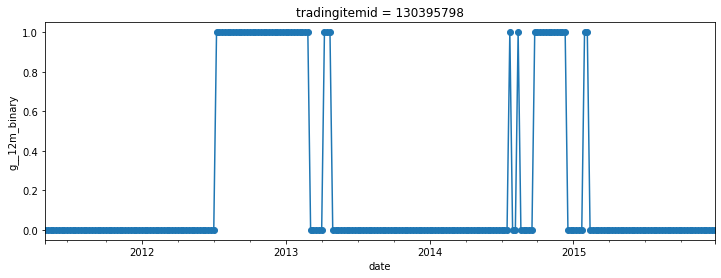

In [4]:
# Look's like  the values of the target variable can change in a short period of time:
plot_feature_changes("g__12m_binary", labels)

In [3]:
# Represent metric to array-like format:
labels = labels["g__12m_binary"]

# #############################################################################
### Split data for train, test & validate. 
Let's use Forward-Chaining method with 1-year steps and a ﬁxed starting date to generate cross validation indexes. Let's use catboost solver for our purposes. According to [benchmarks](https://catboost.ai/#benchmark) this model can outperform the other libraries for gradient boosting on decision trees.

In [4]:
cv_splits_dts = ["2014-12-25", "2013-12-25", "2012-12-25", "2011-12-25", "2010-12-25", 
                 "2009-12-25", "2008-12-25", "2007-12-25", "2006-12-25"]

cv = [train_test_split(train, dt) for dt in cv_splits_dts]

For 2014-12-25 n samples:	 train: 1926552(91%),	 test: 180256(9%)
For 2013-12-25 n samples:	 train: 1746218(83%),	 test: 180334(9%)
For 2012-12-25 n samples:	 train: 1575528(75%),	 test: 170690(8%)
For 2011-12-25 n samples:	 train: 1405933(67%),	 test: 169595(8%)
For 2010-12-25 n samples:	 train: 1228377(58%),	 test: 177556(8%)
For 2009-12-25 n samples:	 train: 1050059(50%),	 test: 178318(8%)
For 2008-12-25 n samples:	 train: 882207(42%),	 test: 167852(8%)
For 2007-12-25 n samples:	 train: 696427(33%),	 test: 185780(9%)
For 2006-12-25 n samples:	 train: 488681(23%),	 test: 207746(10%)


#### Lets use TimeTuneSolver which help us to use our solver with CalibratedClassifierCV from sklearn and do inner loop for Forward-Chaining Nested Cross-Validation. CalibratedClassifierCV help us to iterate over cv cplits and do Platt calibration on tests datasets. We can add some hyperparameter optimizer, like bayesian optimization or Distributed Hyperparameter Optimization(Hyperopt) to train process to make our model more accurate. This will require additional len(cv) * optimization time to train.
Ex.:
```python
from functools import partial
optimizer = partial(
    bayesopt,
    solver = solver13.Solver,
    space = solvers_bopt_spaces.solver13_space,
    space_to_params = solvers_bopt_spaces.solver13_space_to_params,
    init_points = 5, 
    opt_time = 7200, # optimization time, s
    verbose=0
    )
```

In [5]:
model = TimeTuneSolver(solver=solver13.Solver, optimizer=None)
calibrated_model = CalibratedClassifierCV(
    base_estimator=model,
    cv=cv
    )
calibrated_model.fit(train, labels);

In [8]:
# Save output prediction for test dataset to file

result = pd.DataFrame(index=test.index)
result["g__12m_binary"] = calibrated_model.predict_proba(test)[:, 1]
result.to_pickle("./data/test_outcomes.pkl")

# #############################################################################
### Some calibration plots.
#### Lets build Calibration plot for our classifier, as expected our prediction are well calibrated:

In [6]:
train_idx, test_idx = cv[0] # let's use split with test part, which was not used in train in any loop

Log loss:	 0.669
Brier score:	 0.238
Accuracy:	 0.593
Roc auc:	 0.625


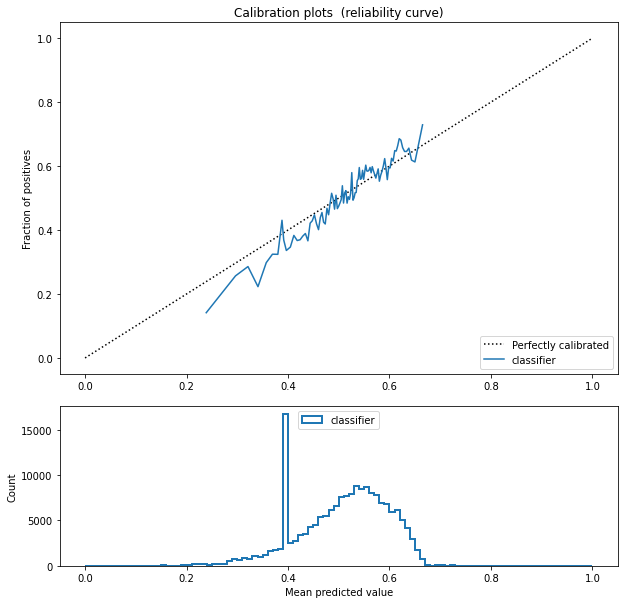

In [10]:
# there is a pick value on the prediction histogram, defined by nan values of most important features (See feature importance section below)
y_labels = labels[test_idx]
prob_pos = calibrated_model.predict_proba(train[test_idx])[:, 1]

calculate_metrics(y_labels, prob_pos)
plot_calibration_plot(y_labels, prob_pos, n_bins=100, strategy="quantile")

#### Lets build Calibration plot for Catboost base estimator, which we use as Solver. It's good calibrated by default. Metrics are slightly worse than after ensemble:

Log loss:	 0.676
Brier score:	 0.241
Accuracy:	 0.581
Roc auc:	 0.611


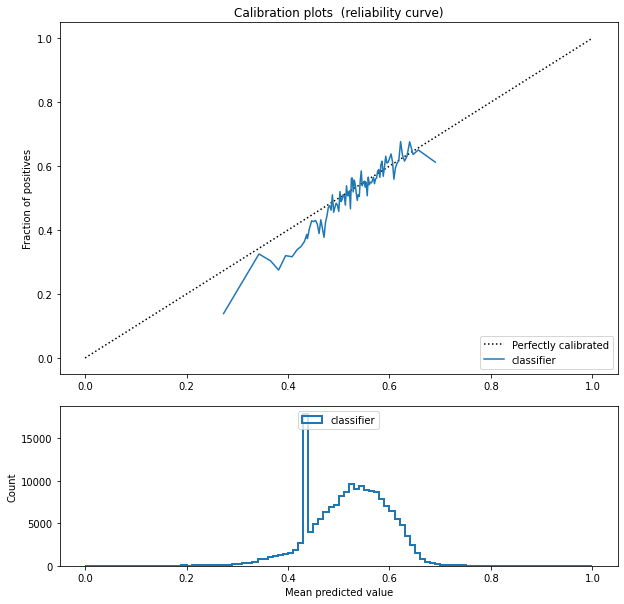

In [19]:
y_labels = labels[test_idx]
clf0 = calibrated_model.calibrated_classifiers_[8]
prob_pos = clf0.base_estimator.predict_proba(train[test_idx])[:, 1]

calculate_metrics(y_labels, prob_pos)
plot_calibration_plot(y_labels, prob_pos, n_bins=100, strategy="quantile")

# #############################################################################
### Let's see some feature importance

In [7]:
import shap
shap.initjs()

In [14]:
clf0 = calibrated_model.calibrated_classifiers_[0].base_estimator.model_.model_

explainer = shap.TreeExplainer(clf0)
X = train[test_idx][:100]
shap_values = explainer.shap_values(X)

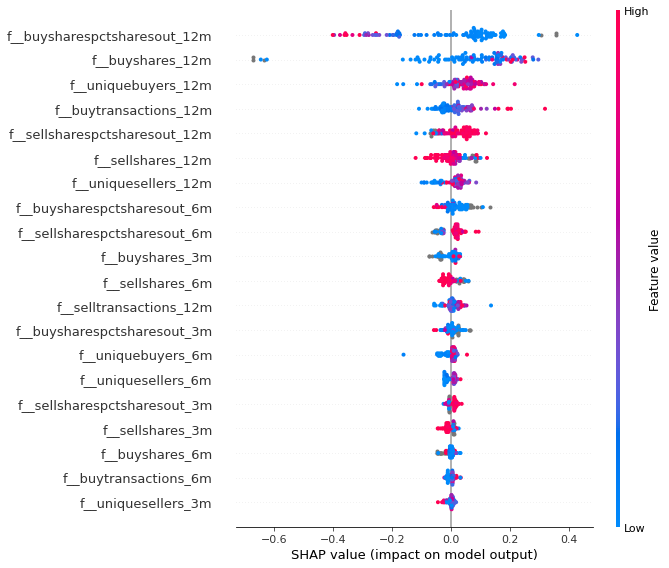

In [10]:
# visualize the features impact on model, most important features - stats by 12m as a target
shap.summary_plot(shap_values, X)

In [11]:
# let's see what what was important for predictions in histogram pick between 0.39 & 0.395 
y_pred = clf0.predict_proba(train[test_idx])[:, 1]
X = train[test_idx][(0.39<y_pred)&(y_pred<0.395)][:100]
shap_values = explainer.shap_values(X)

In [12]:
# Nan values of most important features is reason why predictions took they value
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:], link='logit')

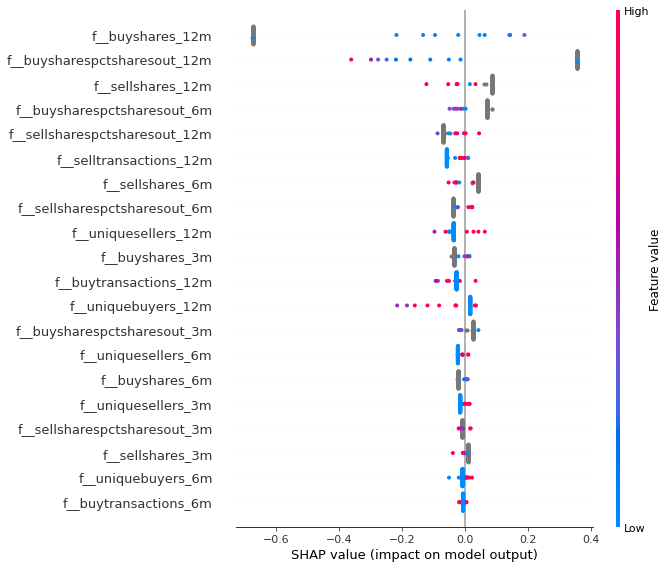

In [37]:
# Nan values is reason for no divergence in predictions
shap.summary_plot(shap_values, X)

# #############################################################################
### Next steps to improve result:
1. Make more feature engineering
2. Add more solvers
3. Apply some optimizers during train
4. Stack result models
